In [1]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.89.1
    Uninstalling fastapi-0.89.1:
      Successfully uninstalled fastapi-0.89.1


In [2]:
!pip install transformers

In [3]:
!pip install torchmetrics

In [4]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertModel
import torchtext
import numpy as np
import pandas as pd
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint, Callback
from torchmetrics import Accuracy, F1Score
import matplotlib.pyplot as plt 

# utils

## dataset

In [11]:
class EmpathyConversationDataset(Dataset):
    

    FILE_PATH = {'train': "/kaggle/input/dialogue-empathy-detection/train.csv",
                 'test': "/kaggle/input/dialogue-empathy-detection/test.csv",
                 'val': "/kaggle/input/dialogue-empathy-detection/val.csv",}

    def __init__(self, split="train", transforms=None):

        if split.lower() not in self.FILE_PATH.keys():
            raise Exception("must be train or test or val")

        df = pd.read_csv(self.FILE_PATH[split.lower()])
        df = self.conv_preprocess(df)
        
        self.x = df[['utterance']].to_numpy()
        self.y = df[['empathy']].to_numpy()
        self.n_sample = len(df)

        self.transforms = transforms
    
    def conv_preprocess(self, df):
        return df.groupby('conv_id')['utterance'].apply(list).reset_index().\
                  merge(df.groupby('conv_id')['empathy'].max().reset_index(), on='conv_id', how="inner")

    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        return self._pipline_transforms(sample)
    
    def _pipline_transforms(self, sample):
        if self.transforms:
            for transform in self.transforms:
                sample = transform(sample)
        return sample
    
    def __len__(self):
        return self.n_sample

In [12]:
class TextListCleaner:

    punc = '''!()-[]{.};:'"\,<>/?@#$%^&*_~`|’“”…—–'''

    def __call__(self, sample):
        texts, target = sample
        texts = texts[0]
        new_texts = list()
        
        for text in texts:
            text = text.lower()
            for each in self.punc:
                text = text.replace(each, ' ')
            new_texts.append(text)
        return np.array([new_texts]), target


class ConversationFormater:
    SPECIAL_TOKEN_START_UTTERANCE = "<BOU>"
    SPECIAL_TOKEN_END_UTTERANCE = "<EOU>"  
    
    def __call__(self, sample):
        texts, target = sample
        texts = texts[0]
        
        conversation = str()
        for text in texts:
            conversation += f"{self.SPECIAL_TOKEN_START_UTTERANCE} {text} {self.SPECIAL_TOKEN_END_UTTERANCE} "
        return np.array([conversation]), target

    
class Tokenizer:

    def __init__(self, version="bert-base-uncased", max_len=128, tokenizer=None, new_special_tokens=None):
        self.tokenizer = AutoTokenizer.from_pretrained(version) if tokenizer is None else tokenizer
        
        if new_special_tokens:
            tokenizer.add_special_tokens(new_special_tokens)
            
        self.MAX_LEN = max_len

    def __call__(self, sample):
        text, target = sample
        inputs = self.tokenizer.encode_plus(text[0], add_special_tokens=True, max_length=self.MAX_LEN, padding='max_length', 
                                             return_attention_mask=True, return_token_type_ids=True, truncation=True)
        return inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids'], target


class ToTensor:
    # Convert ndarrays to Tensors
    def __call__(self, sample):
        return tuple(torch.from_numpy(np.array(each)) for each in sample)
    

class OneHotLabel:
    
    def __init__(self, num_classes):
        self.num_classes = num_classes
    
    def __call__(self, sample):
        target = sample[-1]
        target = torch.squeeze(torch.nn.functional.one_hot(target, num_classes=self.num_classes), dim=0)
        sample = list(sample[:-1]) + [target]
        return tuple(sample)

In [13]:
class HistoryCallback(Callback):

    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append({key: value.item() for key, value in trainer.callback_metrics.items()})

# GPT-2

In [14]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [15]:
pip_trans = [TextListCleaner(), 
             ConversationFormater(),
             Tokenizer(tokenizer=tokenizer, new_special_tokens={'additional_special_tokens': [ConversationFormater.SPECIAL_TOKEN_START_UTTERANCE,
                                                                                              ConversationFormater.SPECIAL_TOKEN_END_UTTERANCE],
                                                               'pad_token': '[PAD]'},
                        max_len=512),
             ToTensor()]

In [10]:
tokenizer.all_special_tokens

['<|endoftext|>', '[PAD]', '<BOU>', '<EOU>']

In [16]:
train_dataset = EmpathyConversationDataset(transforms=pip_trans)
test_dataset = EmpathyConversationDataset(split="test", transforms=pip_trans)
val_dataset = EmpathyConversationDataset(split="val", transforms=pip_trans)

In [12]:
train_dataset[0]

(tensor([50257,    72,   285,  ..., 50259, 50259, 50259]),
 tensor([1, 1, 1,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0]))

In [12]:
weights = torch.zeros(1)
for _, _, _, target in train_dataset:
    weights += target
weights, len(train_dataset)

(tensor([2324.]), 3308)

In [17]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=4)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=4)

In [14]:
from transformers import GPT2Config
print(GPT2Config())

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.27.4",
  "use_cache": true,
  "vocab_size": 50257
}



In [25]:
import torch
torch.cuda.empty_cache()

In [18]:
from transformers import GPT2Model
from transformers import GPT2Config


class EmpathyDetectionGPT2Model(pl.LightningModule):
    
    LOSS = torch.nn.BCEWithLogitsLoss()
    accuracy = Accuracy(task="binary").to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    f1 = F1Score(task="binary").to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    def __init__(self, embedding_tokens_len=None, config=GPT2Config()):
        super().__init__()
        self.transformer_model = GPT2Model(config)
        if embedding_tokens_len:
            # when transformer_model.wte.weight.shape[0] != len(tokenizer)
            self.transformer_model.resize_token_embeddings(embedding_tokens_len)
        self.drop = torch.nn.Dropout(0.5)
        self.out = torch.nn.Linear(768, 1)

    def forward(self, ids, mask, token_type_ids):
        x = self.transformer_model(ids, attention_mask=mask, token_type_ids=token_type_ids)[0].mean(dim=1)
        x = self.drop(x)
        output = self.out(x)
        return output
    
    def training_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        self.log_dict({"train_loss": loss, "train_accuracy": acc},on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        val_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        self.log_dict({"val_loss": val_loss, "val_accuracy": acc}, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        ids, mask, token_type_ids, y = batch
        pred = self(ids, mask, token_type_ids)
        test_loss = self.LOSS(pred, y.float())
        acc = self.accuracy(pred, y.float())
        f1_score = self.f1(pred, y.float())
        self.log_dict({"test_loss": test_loss, "test_accuracy": acc, "test_f1": f1_score}, 
                      on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
        return test_loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-6)
        return optimizer

In [19]:
config = GPT2Config(n_positions=512)

In [20]:
model = EmpathyDetectionGPT2Model(embedding_tokens_len=len(tokenizer), config=config)

In [21]:
model.transformer_model.config

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 512,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.27.4",
  "use_cache": true,
  "vocab_size": 50260
}

In [22]:
model_checkpoint = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    dirpath="./gpt2",
    filename="gpt2-empathy-conv-{epoch:02d}-{val_loss:.2f}",
)
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
history_callback = HistoryCallback()
trainer = pl.Trainer(limit_train_batches=100, max_epochs=50, callbacks=[history_callback, early_stop, model_checkpoint], accelerator='auto')

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type      | Params
------------------------------------------------
0 | transformer_model | GPT2Model | 124 M 
1 | drop              | Dropout   | 0     
2 | out               | Linear    | 769   
------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
496.199   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [24]:
history_df = pd.DataFrame(history_callback.metrics)
history_df.dropna(inplace=True)

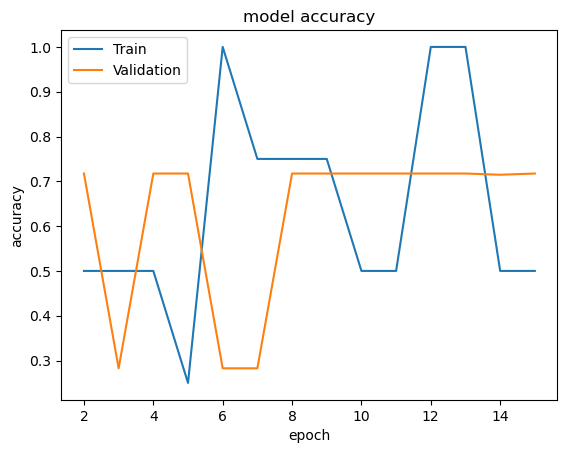

In [25]:
plt.plot(history_df.train_accuracy)
plt.plot(history_df.val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

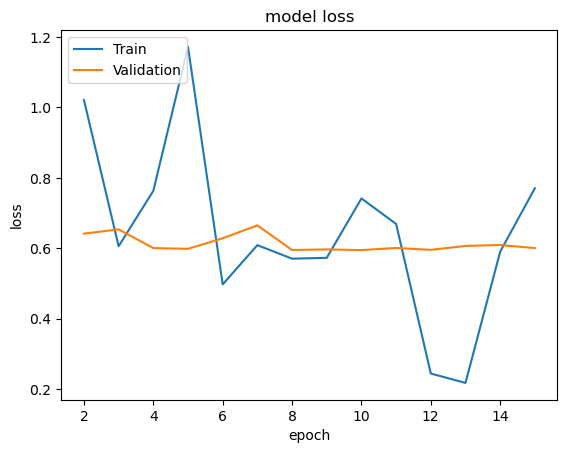

In [26]:
plt.plot(history_df.train_loss)
plt.plot(history_df.val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [27]:
trainer.test(model, dataloaders=test_dataloader, ckpt_path='best')

INFO: Restoring states from the checkpoint path at /kaggle/working/gpt2/gpt2-empathy-conv-epoch=09-val_loss=0.59.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from checkpoint at /kaggle/working/gpt2/gpt2-empathy-conv-epoch=09-val_loss=0.59.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_accuracy_epoch    │    0.6919315457344055     │
│       test_f1_epoch       │     0.782978355884552     │
│      test_loss_epoch      │     0.617950975894928     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.617950975894928,
  'test_accuracy_epoch': 0.6919315457344055,
  'test_f1_epoch': 0.782978355884552}]